##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
import pandas as pd
from torchvision.ops import nms
from tqdm import tqdm
from ultralytics import YOLO

#### The model performance on the evalution dataset (test dataset)

##### load yolo

In [2]:
# Load the custom-trained weights
model = YOLO('trained_models/YOLOv8_training/weights/best.pt')

In [3]:
threshold = 0.1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(DEVICE)

dataset_dir = "Evaluation_dataset"

##### Evaluate the model

In [4]:
class FacadeDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        
        # Load the merged annotation file
        annotation_path = os.path.join(dataset_dir, "merged.json")
        with open(annotation_path) as f:
            data = json.load(f)

        # Map image_id to file_name
        self.image_id_to_filename = {img["id"]: img["file_name"] for img in data["images"]}
        
        # Store annotations indexed by image_id
        self.annotations = {}
        for ann in data["annotations"]:
            image_id = ann["image_id"]
            if image_id not in self.annotations:
                self.annotations[image_id] = []
            self.annotations[image_id].append(ann)

        # List of image filenames (ensuring they have annotations)
        self.image_files = [file_name for img_id, file_name in self.image_id_to_filename.items() if img_id in self.annotations]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.dataset_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Get the image ID
        image_id = next(k for k, v in self.image_id_to_filename.items() if v == img_name)

        # Retrieve annotation data for this image
        annotations = self.annotations.get(image_id, [])

        boxes = []
        labels = []

        for ann in annotations:
            bbox = ann["bbox"]  # COCO format: [x_min, y_min, width, height]
            x_min, y_min, width, height = bbox
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(1)  # Assuming category_id 1 is for windows

        # Convert bounding boxes and labels to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        original_width, original_height = image.size

        if self.transform:
            for t in self.transform.transforms:
                if isinstance(t, transforms.Resize):
                    new_size = t.size
                    if isinstance(new_size, int):  
                        aspect_ratio = original_width / original_height
                        new_width = new_size if original_width > original_height else int(new_size * aspect_ratio)
                        new_height = new_size if original_width <= original_height else int(new_size / aspect_ratio)
                    else:
                        new_height, new_width = new_size

                    scale_x, scale_y = new_width / original_width, new_height / original_height
                    boxes[:, [0, 2]] *= scale_x  
                    boxes[:, [1, 3]] *= scale_y  

            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target

In [5]:
# Define transformations
transform = transforms.Compose([
    # transforms.Resize((image_new_dimension, image_new_dimension)),
    transforms.ToTensor()
])

val_dataset = FacadeDataset(dataset_dir, transform=transform)
print(f"Total images with annotations: {len(val_dataset)}")

Total images with annotations: 477


In [6]:
val_loader = DataLoader(val_dataset, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
import torch
from torchvision.ops import box_iou, nms
from tqdm import tqdm

# Metric Evaluation
model.val()  # Use .val() for YOLO
with torch.no_grad():
    val_loader_tqdm = tqdm(val_loader, desc="Validating Metrics", leave=False)
    all_precisions, all_recalls, all_f1s, all_ious = [], [], [], []

    for _, (images, targets) in enumerate(val_loader_tqdm):
        images = images[0].to(DEVICE)  # Unpack images tensor from tuple

        # Get predictions from YOLO (assumed shape: (batch, N, 6) -> [x1, y1, x2, y2, conf, class_id])
        outputs = model(images)

        pred_boxes = []
        pred_confidences = []
        for output in outputs:
            if output.numel() == 0:  # No detections
                pred_boxes.append(torch.empty((0, 4)))
                pred_confidences.append(torch.empty((0,)))
                continue

            boxes = output[:, :4].cpu()  # Extract bounding boxes
            scores = output[:, 4].cpu()  # Extract confidence scores

            high_conf_mask = scores > threshold  # Confidence filtering
            boxes = boxes[high_conf_mask]
            scores = scores[high_conf_mask]

            # Apply NMS
            if boxes.size(0) > 0:
                indices = nms(boxes, scores, iou_threshold=threshold)
                boxes = boxes[indices]
                scores = scores[indices]

            pred_boxes.append(boxes)
            pred_confidences.append(scores)

        # Extract ground truth boxes
        target_boxes = [target['boxes'].cpu() for target in targets]

        # Calculate precision, recall, F1 at IoU 0.5 threshold
        for pb, tb in zip(pred_boxes, target_boxes):
            if pb.size(0) > 0 and tb.size(0) > 0:
                init_iou = box_iou(pb, tb)
                tp = (init_iou >= threshold).sum().item()  # True positives at IoU=0.5
                fp = pb.size(0) - tp  # False positives
                fn = tb.size(0) - tp  # False negatives

                iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                all_ious.append(iou)
                all_precisions.append(precision)
                all_recalls.append(recall)
                all_f1s.append(f1)

    # Calculate mean metrics over the entire validation set
    mean_iou = sum(all_ious) / len(all_ious) if all_ious else 0
    mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
    mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
    mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

    print(f"  Mean IoU: {mean_iou:.4f}")
    print(f"  Precision: {mean_precision:.4f}")
    print(f"  Recall: {mean_recall:.4f}")
    print(f"  F1 Score: {mean_f1:.4f}")


#### WWR calculation

In [10]:
# Define the path to your image
file_name = "rectified_facade_DENW11AL0000h3Gt.jpg"

image_path = os.path.join("Evaluation_subset", file_name)

In [11]:
# Load the JSON file
file_path = os.path.join("Evaluation_subset", "labels_facade_dataset_2024-06-09-08-43-50.json")
with open(file_path, 'r') as f:
    data = json.load(f)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)

##### Facade area in meters

In [13]:
# Load the Excel file
file_path = "soest_duesseldorf_combined_valid_results_with_geometry_with_width.xlsx"
df = pd.read_excel(file_path, dtype=str)  # Read as strings to avoid type issues

# Extract the gmlid from the filename
gmlid = file_name.replace("rectified_facade_", "").replace(".jpg", "")

# Search for the corresponding row
row = df[df["gmlid"] == gmlid]

if not row.empty:
    # Retrieve relevant facade height and width
    facade_height_meters = float(row["relevant_facade_height"].values[0])
    facade_width_meters = float(row["relevant_facade_width"].values[0])

    # Compute facade area
    facade_area = facade_height_meters * facade_width_meters

    rich.print(f"GMLID: {gmlid}")
    rich.print(f"Facade Height: {facade_height_meters} meters")
    rich.print(f"Facade Width: {facade_width_meters} meters")
    rich.print(f"Facade Area: {facade_area} square meters")
else:
    rich.print(f"No matching GMLID found for {gmlid}.")

GMLID: DENW11AL0000h3Gt

Facade Height: 9.081 meters

Facade Width: 11.26536719358218 meters

Facade Area: 102.30079948491978 square meters

In [ ]:
# Load the Excel file
file_path = "soest_duesseldorf_combined_valid_results_with_geometry_with_width.xlsx"
df = pd.read_excel(file_path, dtype=str)  # Read as strings to avoid type issues

# Extract the gmlid from the filename
gmlid = file_name.replace("rectified_facade_", "").replace(".jpg", "")

# Search for the corresponding row
row = df[df["gmlid"] == gmlid]

if not row.empty:
    # Retrieve relevant facade height and width
    facade_height_meters = float(row["relevant_facade_height"].values[0])
    facade_width_meters = float(row["relevant_facade_width"].values[0])

    # Compute facade area
    facade_area = facade_height_meters * facade_width_meters

    rich.print(f"GMLID: {gmlid}")
    rich.print(f"Facade Height: {facade_height_meters} meters")
    rich.print(f"Facade Width: {facade_width_meters} meters")
    rich.print(f"Facade Area: {facade_area} square meters")
else:
    rich.print(f"No matching GMLID found for {gmlid}.")

GMLID: DENW11AL0000h3Gt

Facade Height: 9.081 meters

Facade Width: 11.26536719358218 meters

Facade Area: 102.30079948491978 square meters

##### image area in pixels

In [14]:
# Step 1: Find the image details for the given file name
image_details = next(item for item in data["images"] if item["file_name"] == file_name)

# Extract width and height
image_height_pixels = image_details["height"]
image_width_pixels = image_details["width"]

rich.print(f"Image Height: {image_height_pixels} pixels")
rich.print(f"Image Width: {image_width_pixels} pixels")

# Calculate the image area
image_area_pixels = image_height_pixels * image_width_pixels

# rich.print(f"Image dimensions for '{file_name}': {image_width}x{image_height}")
rich.print(f"Total image area for '{file_name}': {image_area_pixels} pixels²")

Image Height: 272 pixels

Image Width: 337 pixels

Total image area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 91664 pixels²

##### Pixel size in square meters

In [15]:
# Calculate the pixel size in square meters
pixel_size_meters = (facade_width_meters / image_width_pixels) * (
        facade_height_meters / image_height_pixels)

rich.print("pixel size in meters", pixel_size_meters)

pixel size in meters 0.001116041188306421

##### Ground truth area

In [16]:
image_id = next(item["id"] for item in data["images"] if item["file_name"] == file_name)

# Step 2: Filter annotations for the image_id and category "window" (category_id = 1)
window_annotations = [
    annotation for annotation in data["annotations"]
    if annotation["image_id"] == image_id and annotation["category_id"] == 1
]

# Step 3: Calculate total area and count
windows_area_gt = sum(ann["area"] for ann in window_annotations)
num_windows = len(window_annotations)

# rich.print(f"Number of windows: {num_windows}")
rich.print(f"Total window area for '{file_name}': {windows_area_gt} pixels²")

Total window area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 21784.693692249522 pixels²

##### Calculate the predicted area

In [17]:
# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
with torch.no_grad():
    predictions = model(input_image)
    # rich.print("predictions", predictions)

# Extract predictions from the output
boxes = predictions[0]['boxes']
scores = predictions[0]['scores']

# Filter boxes by scores > 0.5
threshold = 0.1
valid_boxes = boxes[scores > threshold]

# Get the count of valid boxes
num_valid_boxes = valid_boxes.shape[0]

# Calculate the area of each valid bounding box
areas = (valid_boxes[:, 2] - valid_boxes[:, 0]) * (valid_boxes[:, 3] - valid_boxes[:, 1])

# Sum the areas to get windows_area
windows_area_p = areas.sum().item()

# Print the total windows area
# rich.print(f"Number of valid boxes: {num_valid_boxes}")
rich.print(f"Total predicted windows area for '{file_name}': {windows_area_p} pixels²")

Total predicted windows area for 'rectified_facade_DENW11AL0000h3Gt.jpg': 11663.39453125 pixels²

##### WWR actual and predicted in pixels

In [18]:
# Calculate ground truth WWR
wwr_gt = windows_area_gt / image_area_pixels if image_area_pixels > 0 else 0

rich.print(f"Window-to-Wall Ratio (ground truth) (WWR) for '{file_name}': {wwr_gt:.4f}")

# Calculate predicted WWR
wwr_P = windows_area_p / image_area_pixels if image_area_pixels > 0 else 0

rich.print(f"Window-to-Wall Ratio (predcited) (WWR) for '{file_name}': {wwr_P:.4f}")

# Calculate the absolute difference
wwr_difference = abs(wwr_gt - wwr_P)

# Optionally, calculate percentage difference
wwr_percentage_diff = (wwr_difference / wwr_gt * 100) if wwr_gt > 0 else 0

# Print the results
# rich.print(f"[bold]Difference between ground truth and predicted WWR:[/bold] {wwr_difference:.4f}")
# rich.print(f"[bold]Percentage difference:[/bold] {wwr_percentage_diff:.2f}%")

Window-to-Wall Ratio (ground truth) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.2377

Window-to-Wall Ratio (predcited) (WWR) for 'rectified_facade_DENW11AL0000h3Gt.jpg': 0.1272

##### WWR actual in meters

In [19]:
facade_meters = image_area_pixels * pixel_size_meters

rich.print(f"facade in meters {facade_meters} meters²")

facade in meters 102.30079948491976 meters²

In [20]:
window_meters_GT = windows_area_gt * pixel_size_meters

rich.print(f"windows in meters ground trught {window_meters_GT} meters²")

windows in meters ground trught 24.31261543518955 meters²

In [21]:
WWR_GT_actual = window_meters_GT / facade_meters

rich.print(f"WWR Ground trugth {WWR_GT_actual}")

WWR Ground trugth 0.23765811760614333

##### WWR predicted in meters

In [22]:
window_meters_P = windows_area_p * pixel_size_meters

rich.print(f"windows in meters predcited {window_meters_P} meters²")

windows in meters predcited 13.01682869234286 meters²

In [23]:
WWR_p_actual = window_meters_P / facade_meters

rich.print(f"WWR predicted {WWR_p_actual}")

WWR predicted 0.1272407327985905

#### Visualizing the results (Faster RCNN) on the Evalution subset

In [24]:
def visualize_predictions(predictions, image_tensor, threshold=0.5, class_names=None):
    """
    Visualizes predictions on an image.

    Args:
        predictions (dict): The predictions dictionary from Faster R-CNN, containing 'boxes', 'labels', and 'scores'.
        image_tensor (Tensor): The image tensor.
        threshold (float): Confidence threshold to filter boxes.
        class_names (list): List of class names, where index corresponds to class label (optional).
    """
    # Convert the tensor to a PIL image
    img = transforms.ToPILImage()(image_tensor.cpu())
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()

    # Draw each bounding box
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:  # Filter boxes by score
            x_min, y_min, x_max, y_max = box.detach().cpu().numpy()
            width, height = x_max - x_min, y_max - y_min

            # Draw the rectangle
            rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Get label name if provided, otherwise use label index
            label_text = class_names[label] if class_names else f"Class {label}"
            label_text = f"{label_text}: {score:.2f}"

            # Add label and score
            ax.text(x_min, y_min - 10, label_text, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

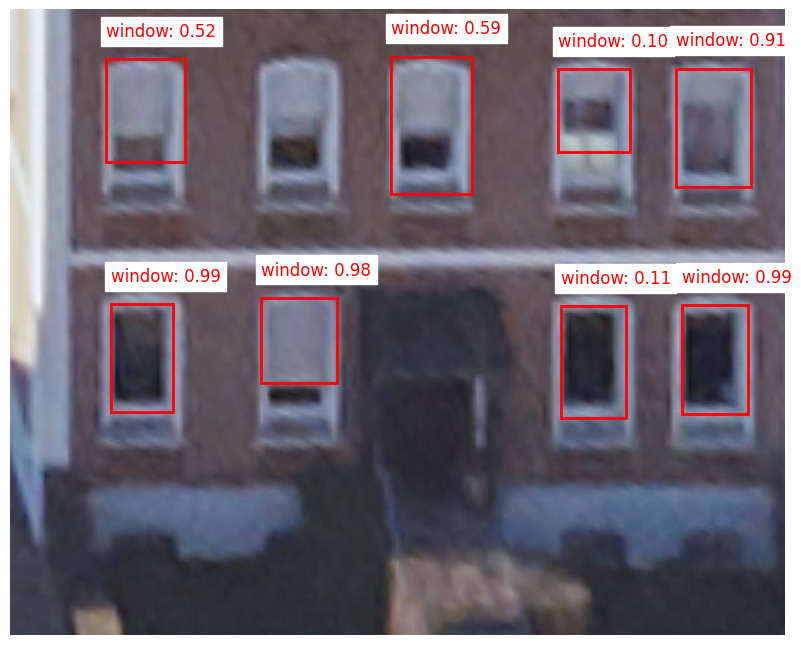

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)
# Define the path to your image
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
with torch.no_grad():
    predictions = model(input_image)
    # rich.print("predictions", predictions)

# Visualize the predictions
class_names = ["background", "window"]  # Adjust based on your class names
visualize_predictions(predictions[0], input_image[0], threshold=0.1, class_names=class_names)